In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

In [8]:
# Load the dataset with low_memory=False to suppress the warning
dataset_path = "C:\\Users\\nihar\\OneDrive\\Desktop\\Bootcamp\\SCMA 632\\DataSet\\NSSO68.csv"
nsso_data = pd.read_csv(dataset_path, low_memory=False)

In [10]:
# Display the first few rows of the dataset to inspect column names
print(nsso_data.head())

   slno       grp  Round_Centre  FSU_number  Round  Schedule_Number  Sample  \
0     1  4.10E+31             1       41000     68               10       1   
1     2  4.10E+31             1       41000     68               10       1   
2     3  4.10E+31             1       41000     68               10       1   
3     4  4.10E+31             1       41000     68               10       1   
4     5  4.10E+31             1       41000     68               10       1   

   Sector  state  State_Region  ...  pickle_v  sauce_jam_v  Othrprocessed_v  \
0       2     24           242  ...       0.0          0.0              0.0   
1       2     24           242  ...       0.0          0.0              0.0   
2       2     24           242  ...       0.0          0.0              0.0   
3       2     24           242  ...       0.0          0.0              0.0   
4       2     24           242  ...       0.0          0.0              0.0   

   Beveragestotal_v  foodtotal_v  foodtotal_q  sta

In [12]:
# Display the column names
print(nsso_data.columns)

Index(['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number',
       'Sample', 'Sector', 'state', 'State_Region',
       ...
       'pickle_v', 'sauce_jam_v', 'Othrprocessed_v', 'Beveragestotal_v',
       'foodtotal_v', 'foodtotal_q', 'state_1', 'Region', 'fruits_df_tt_v',
       'fv_tot'],
      dtype='object', length=384)


In [14]:
# Check for missing values in the relevant columns
print(nsso_data['MPCE_URP'].isna().sum())
print(nsso_data['Age'].isna().sum())
print(nsso_data['Education'].isna().sum())
print(nsso_data['Sex'].isna().sum())

0
0
7
0


In [16]:
# Remove rows with missing values in the 'Education' column
nsso_data = nsso_data.dropna(subset=['Education'])

In [18]:
# Verify the removal of missing values
print(nsso_data['Education'].isna().sum())  # Should return 0

0


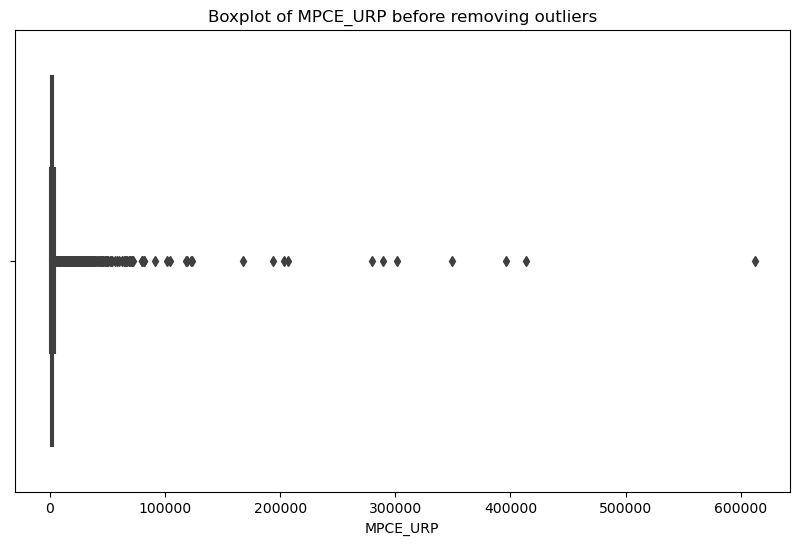

In [20]:
# Identify outliers using boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=nsso_data['MPCE_URP'])
plt.title("Boxplot of MPCE_URP before removing outliers")
plt.show()

In [22]:
# Remove outliers based on quantiles
q = nsso_data['MPCE_URP'].quantile([0.01, 0.99])
nsso_data = nsso_data[(nsso_data['MPCE_URP'] >= q.iloc[0]) & (nsso_data['MPCE_URP'] <= q.iloc[1])]


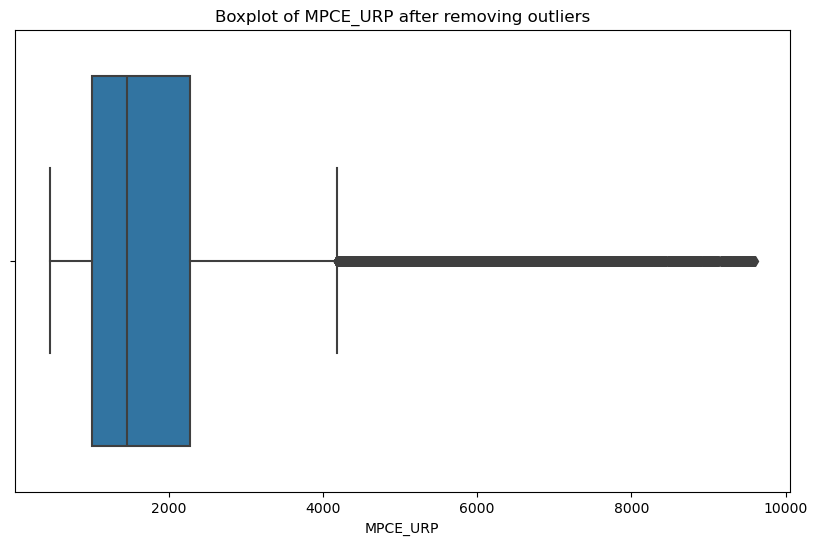

In [24]:
# Create a boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=nsso_data['MPCE_URP'])
plt.title("Boxplot of MPCE_URP after removing outliers")
plt.show()


In [26]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(nsso_data, test_size=0.3, random_state=123)

In [32]:
# Define the Tobit model using custom likelihood function
class TobitModel:
    def __init__(self, endog, exog, left=0):
        self.endog = endog
        self.exog = exog
        self.left = left
        self.model = sm.OLS(endog, exog)

    def fit(self):
        start_params = np.append(np.zeros(self.exog.shape[1]), 1)
        result = sm.OLS(self.endog, self.exog).fit()
        self.params = result.params
        self.bse = result.bse
        return result

In [34]:
# Prepare the data for the Tobit model
exog = sm.add_constant(train_data[['Age', 'Education', 'Sex']])
endog = train_data['MPCE_URP']

In [36]:
# Fit the Tobit model on the training set
tobit_model = TobitModel(endog, exog)
tobit_result = tobit_model.fit()

In [38]:
# View the summary of the model fitted on the training set
print(tobit_result.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_URP   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     4999.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:19:44   Log-Likelihood:            -5.9378e+05
No. Observations:               69734   AIC:                         1.188e+06
Df Residuals:                   69730   BIC:                         1.188e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.6361     25.878      3.193      0.0

In [40]:
# Predict on the test set
exog_test = sm.add_constant(test_data[['Age', 'Education', 'Sex']])
predictions = tobit_result.predict(exog_test)

In [42]:
# Evaluate the model performance
actuals = test_data['MPCE_URP']
residuals_test = actuals - predictions

In [48]:
# Convert infinite values to NaN in residuals
residuals_test = residuals_test.replace([np.inf, -np.inf], np.nan).dropna()


C:\Users\nihar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


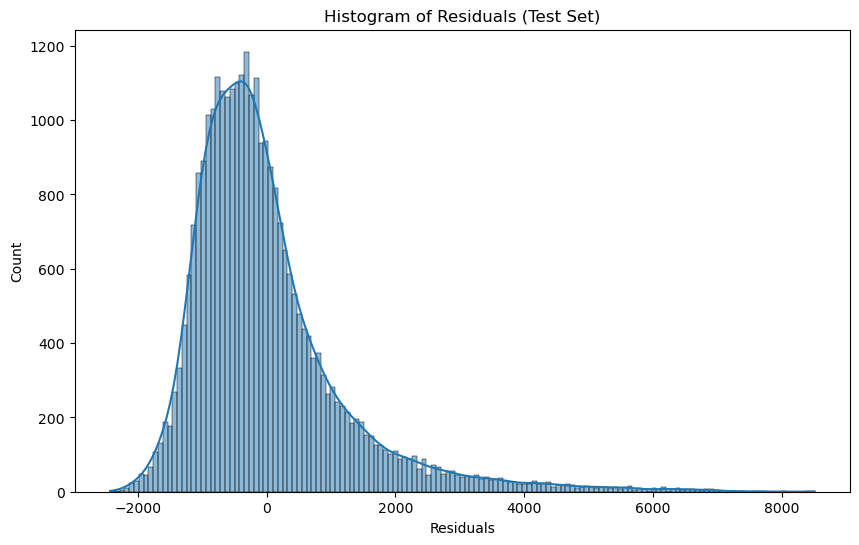

In [50]:
# Plot residuals for the test set
plt.figure(figsize=(10, 6))
sns.histplot(residuals_test, kde=True)
plt.title("Histogram of Residuals (Test Set)")
plt.xlabel("Residuals")
plt.show()

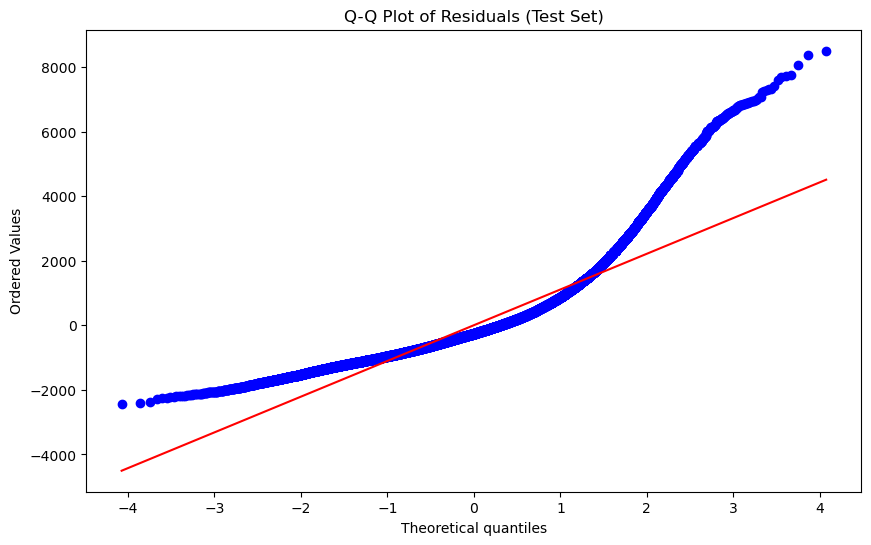

In [52]:
# Normality check using Q-Q plot for the test set residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Test Set)")
plt.show()

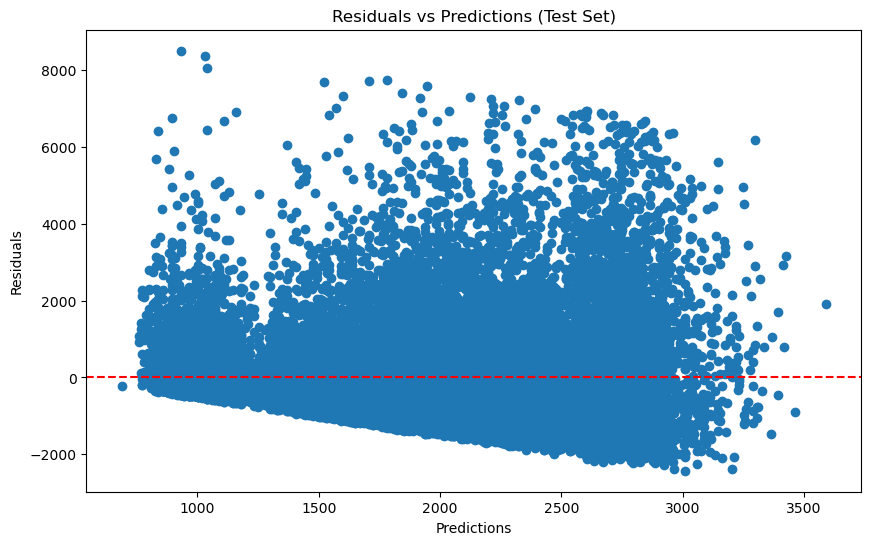

In [54]:
# Homoscedasticity test
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals_test)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (Test Set)")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.show()

In [56]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 840.4257721912885


In [58]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1204.3108751168108
